

Objective: HFO detection and cross-validation

## HFO Dataset
High frequency oscillations (HFOs) are quasi-periodic intracranial EEG transients with durations on the order of tens of milliseconds and peak frequencies in the range of 80 to 500 Hz. There has been considerable interest among the epilepsy research community in the potential of these signals as biomarkers for epileptogenic networks.

We will explore a dataset of candidate HFOs detected using the algorithm of Staba et al. The raw recordings from which this dataset arises come from a human subject with mesial temporal lobe epilepsy and were contributed by the laboratory of Dr. Greg Worrell at the Mayo Clinic in Rochester, MN.

The dataset ``I521_A0004_D001`` contains raw HFO clips that are normalized to zero mean and unit standard deviation but are otherwise unprocessed. The raw dataset contains two channels of data: Test_raw_norm and Train_raw_norm, storing raw testing and training sets of HFO clips respectively. The raw dataset also
contains two annotation layers: Testing windows and Training windows, storing HFO clip start and stop times (in microseconds) for each of the two channels above. Annotations contain the classification by an "expert" reviewer (i.e., a doctor) of each candidate HFO as either an HFO (2) or an artifact (1). On ieeg.org and upon downloading the annotations, you can view this in the "description" field.


In [92]:
#Set up the notebook environment
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
import datetime
import time
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold

  Cloning https://github.com/ieeg-portal/ieegpy.git to /private/var/folders/z9/c1d0wps56vz4463fn1pg56900000gn/T/pip-req-build-e10uwfsj
  Running command git clone -q https://github.com/ieeg-portal/ieegpy.git /private/var/folders/z9/c1d0wps56vz4463fn1pg56900000gn/T/pip-req-build-e10uwfsj
  Created wheel for ieeg: filename=ieeg-1.6-cp37-none-any.whl size=27505 sha256=1abaf606b86b64b82f55dc2560d588ef6407a4e3502ff50334df951cf705250a
  Stored in directory: /private/var/folders/z9/c1d0wps56vz4463fn1pg56900000gn/T/pip-ephem-wheel-cache-h14dahrm/wheels/df/5b/ec/1b8d96d63b0d7dad034960ef592d6199dbe1017ffee6794ac6
Successfully built ieeg


Let's familiarize ourselves with IEEG's annotation object.

1. From an IEEG `Dataset` object, we can call `.get_annotation_layers()`, which returns a dictionary where the keys are the names of the annotation layers, and the associated values are the number of annotations per layer.

2. We can load annotations from IEEG.org using the `.get_annotations(ANNOTATION_LAYER_NAME)` function. This returns a list of IEEG `Annotation` objects for the annotation layer you specified (by name). 

3. The `Annotation` object itself has three important attributes:

>> `.description` tells you the value of the annotation (1 for Artifact, 2 for HFO)

>> `.start_time_offset_usec` tells you the starting timepoint of the annotation in microseconds

>> `.end_time_offset_usec` tells you the ending timepoint of the annotation in microseconds.

We give you a `load_annotations(dataset, annotation_layer_name)` function to easily load annotations from IEEG. This function takes two arguments: the IEEG `Dataset` object and the name of the annotation layer you want to load (given to you using `.get_annotation_layers()`). The function returns two objects. The first is an (n x 3) array with each of the n annotation's description, start_time_offset_usec, and end_time_offset_usec, respectively. The second is a list with the `Annotation` objects themselves. 

In [93]:
def load_annotations(dataset, annotation_layer_name):
  """
  Loads annotations for the specified annotation layer
  Input: 2 arguments
    dataset: the IEEG Dataset object
    annotation_layer_name: the name of the annotation layer (str)
  Returns: 2 objects
    (n x 3) numpy array. [i, :] contains the description, start_time_offset_usec, and end_time_offset_usec of annotation i, respectively.
    n-sized list. The raw output of the IEEG .get_annotations() function
  """
  #load the annotations
  annotations = dataset.get_annotations(annotation_layer_name)

  #container for annotation information. Set all default values to -1. 
  anno_info = np.zeros((len(annotations), 3)) - 1

  #for each annotation, get the description, start and end times
  for i in range(len(annotations)):
    anno_info[i, 0] = annotations[i].description
    anno_info[i, 1] = annotations[i].start_time_offset_usec
    anno_info[i, 2] = annotations[i].end_time_offset_usec
  
  return [anno_info, annotations]

For convenience, we'll also give you `load_full_channels` again.

In [94]:
def load_full_channels(dataset, duration_secs, sampling_rate, chn_idx):
  """
  Loads the entire channel from IEEG.org
  Input:
    dataset: the IEEG dataset object
    duration_secs: the duration of the channel, in seconds
    sampling_rate: the sampling rate of the channel, in Hz
    chn_idx: the indicies of the m channels you want to load, as an array-like object
  Returns:
    [n, m] numpy array of the channels' values.
  """
  #stores the segments of the channel's data
  chn_segments = []

  #how many segments do we expect?
  num_segments = int(np.ceil(duration_secs * sampling_rate / 6e5))

  #segment start times and the step
  seg_start, step = np.linspace(1, duration_secs*1e6, num_segments, endpoint=False, retstep=True)

  #get the segments
  for start in seg_start:
    chn_segments.append(dataset.get_data(start, step, chn_idx))

  #concatenate the segments vertically
  return np.vstack(chn_segments)

##  Simulating the SABA Detector 
Candidate HFO clips were detected with the Staba et al. algorithm and subsequently validated by an expert as a true HFO or not. In this first section, we will use the original iEEG clips containing HFOs and re-simulate a portion of the Staba detection.

 
How many samples exist for each class (HFO vs. artifact) in the training set?

In [95]:
#Open session data
#open the binary file and use its content to create a session frmo IEEG
with open('tsh_ieeglogin.bin', 'r') as f:
  session = Session('tshepo_yane', f.read())

#get the specified dataset from IEEG
dataset = session.open_dataset('I521_A0004_D001')


In [96]:
# get annotaion of training
annotations_layers= dataset.get_annotation_layers()
annotations_layers.values()

dict_values([200, 420])

In [97]:
anno_info,annotations= load_annotations(dataset,"Training windows")
# get number of HFO in training data
HF0_num=sum(anno_info[:,0]==2) #l HFO labaled 2 in the data
artifact_num=sum(anno_info[:,0]==1) # artifact labaled 1 in the data

print(f'There are {HF0_num} HFO samples and {artifact_num} artifacts in the training data')


There are 101 HFO samples and 99 artifacts in the training data


There are 101 HFO samples  and 99 arftifacts in the data


Using the training set, lets find the first occurrence of the first valid HFO and the first artifact. Using `plt.subplots` with 2 plots, plot the HFO on the left and artifact on the right.

Text(0.5, 1.0, 'Artifact data')

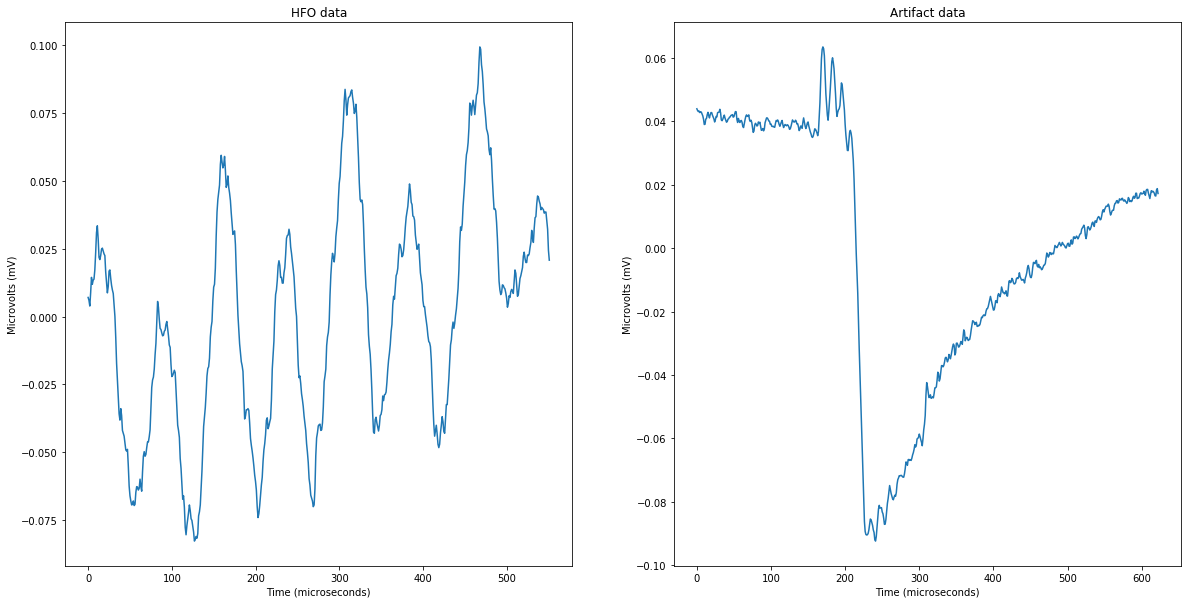

In [98]:
# find the first HFO 
HFO_idx=np.argwhere(anno_info[:,0]==2) #l HFO labaled 2 in the data
HFO_start_time=anno_info[HFO_idx[0],1] # in microseconds
HFO_end_time=anno_info[HFO_idx[0],2] # in microseconds
HFO_duration=HFO_end_time-HFO_start_time

#get array 
HF0_1st_data=dataset.get_data(HFO_start_time,HFO_duration,[1])


# find the first artifact
artifact_idx=np.argwhere(anno_info[:,0]==1) #HFO labaled 1 in the data
artifact_start_time=anno_info[artifact_idx[0],1] # in microseconds
artifact_end_time=anno_info[artifact_idx[0],2] # in microseconds
artifact_duration=artifact_end_time-artifact_start_time

artifact_1st_data=dataset.get_data(artifact_start_time,artifact_duration,[1])

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.plot(HF0_1st_data)
plt.xlabel("Time (microseconds)")
plt.ylabel("Microvolts (mV)")
plt.title("HFO data")

plt.subplot(1,2,2)
plt.plot(artifact_1st_data)
plt.xlabel("Time (microseconds)")
plt.ylabel("Microvolts (mV)")
plt.title("Artifact data")


Create an FIR bandpass filter of order 100 using [`firwin`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html).  

Use Staba et al. (2002) to guide our choice of passband and stopband frequency. Apply our filter using [`filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) to the valid HFO and artifact clips obtained earlier. You will need to make a decision about the input arguments b and a in the `filtfilt` function. Plot these two filtered clips overlayed on their original signal in a two plot `subplot` as before.



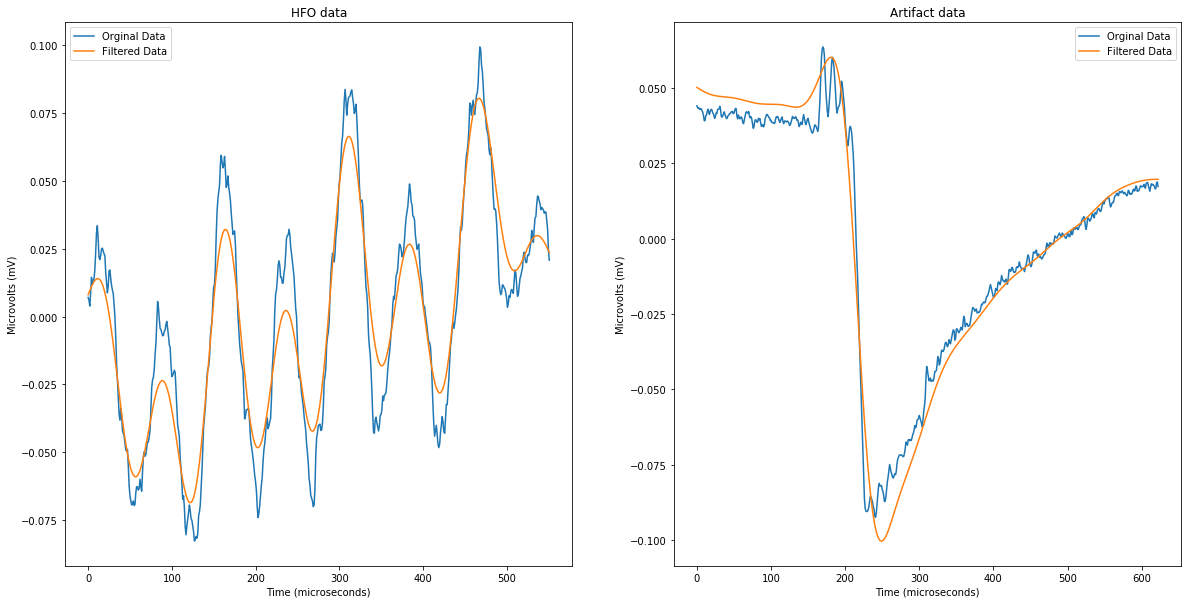

In [99]:
#create a bandpass filter that filters between 80 and 500Hz

labels=dataset.get_channel_labels()
timeseries=dataset.get_time_series_details(labels[1])
sampling_rate= timeseries.sample_rate

#parameters of filter
order=100
numtaps=order+1
f1=80
f2=500
fs=sampling_rate
fil=sig.firwin(numtaps, [f1, f2], pass_zero=False,fs=fs)


HF0_1st_data_filtered = sig.filtfilt(fil, 1, HF0_1st_data, axis=0)


plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.plot(HF0_1st_data,label="Orginal Data")
plt.plot(HF0_1st_data_filtered,label="Filtered Data")
plt.xlabel("Time (microseconds)")
plt.ylabel("Microvolts (mV)")
plt.title("HFO data")
plt.legend()

artifact_1st_data_filtered = sig.filtfilt(fil, 1, artifact_1st_data, axis=0)
plt.subplot(1,2,2)
plt.plot(artifact_1st_data, label="Orginal Data")
plt.plot(artifact_1st_data_filtered,label="Filtered Data")
plt.xlabel("Time (microseconds)")
plt.ylabel("Microvolts (mV)")
plt.title("Artifact data")
plt.legend()



### Speculate how processing the data using Staba's method may have erroneously led to a false HFO detection 

By ony using  Staba's method of passing the data through bandpass filter, only the high freqeuncy noise is removed and a filtered artifact could also be mistaken as a component of the HFO sample when only using peak dection to diffrentiate between the 2 features. For example, if you take a peak in the HFO data at 300ms, using peak detection, you might mistake an artifact for it.

## Defining Features for HFOs

In this section we will be defining a feature space for the iEEG containing HFOs and artifacts. These features will describe certain attributes about the waveforms upon which a variety of classification tools will be applied to better segregate HFOs and artifacts


Create two new matrices, `trainFeats` and `testFeats`, such that the number of rows correspond to observations (i.e., number of training and testing clips) and the number of columns is two. 
Extract the line-length and area features (seen previously in lecture and Homework 3) from the normalized raw signals (note: use the raw signal from ieeg.org, do not filter the signal). Store the line-length value in the first column and area value for each sample in the second column of your features matrices. Make a scatter plot of the training data in the 2-dimensional feature space, coloring the valid detections blue and the artifacts red. (Note: Since we only want one value for each feature of each clip, you will effectively treat the entire clip as the one and only "window".)

In [100]:
#Line length function
def LL(array):
    diff=np.ediff1d(array)
    abs_diff=np.abs(diff)
    sum_abs=np.sum(abs_diff)
    return sum_abs
    
#area function
def area(x):
    return(np.sum(abs(x)))

In [101]:
anno_info_train,annotations_train= load_annotations(dataset,"Training windows")
trainFeats=np.zeros([len(annotations_train)-1,2]) 


for i in range(len(annotations_train)-1):
    #extract time points
    start_time=anno_info_train[i,1]
    end_time=anno_info_train[i,2]
    duration=end_time-start_time

    # extraxt signal
    signal=dataset.get_data(start_time,duration,[1])

    #line length store
    trainFeats[i,0]=LL(signal)

    #area store
    trainFeats[i,1]=area(signal)

In [102]:
anno_info_test,annotations_test= load_annotations(dataset,"Testing windows")
testFeats=np.zeros([len(annotations_test),2]) 


for i in range(len(annotations_test)):
    #extract time points
    start_time=anno_info_test[i,1]
    end_time=anno_info_test[i,2]
    duration=end_time-start_time

    # extraxt signal
    signal=dataset.get_data(start_time,duration,[0])

    #line length store
    testFeats[i,0]=LL(signal)

    #area store
    testFeats[i,1]=area(signal)

Text(0, 0.5, 'Area')

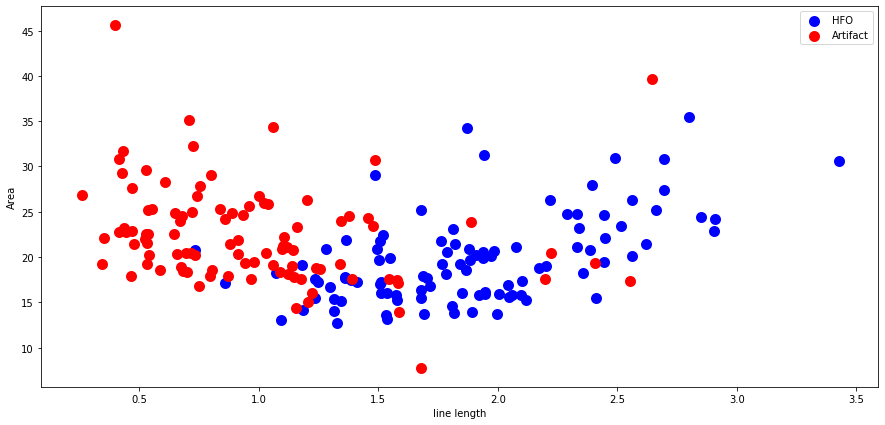

In [103]:
HFO_bool_index=anno_info_train[:,0]==2
artifact_bool_index=anno_info_train[:,0]==1

HFO_bool_index=HFO_bool_index[:-1]
artifact_bool_index=artifact_bool_index[:-1]


Line_length=trainFeats[:,0]
Area=trainFeats[:,1]

#plot data
plt.figure(figsize=[15,7])
plt.scatter(Line_length[HFO_bool_index],Area[HFO_bool_index],color="blue",  label="HFO", linewidths=5)
plt.scatter(Line_length[artifact_bool_index],Area[artifact_bool_index],color="red", label="Artifact",linewidths=5)
plt.legend()
plt.xlabel("line length")
plt.ylabel("Area")


### Feature normalization is often important. 
One simple normalization method is to subtract each feature by its mean and then divide by its standard deviation (creating features with zero mean and unit variance). Using the means and standard deviations calculated in your ***training*** set features, normalize both the training and testing sets. We should use these normalized features for the remainder of this exersices.

In [104]:
#training data normalization
LL_mean_train=np.mean(trainFeats[:,0])
Area_mean_train=np.mean(trainFeats[:,1])

LL_std_train=np.std(trainFeats[:,0])
Area_std_train=np.std(trainFeats[:,1])

norm_LL_train=(trainFeats[:,0]-LL_mean_train)/LL_std_train
norm_Area_train=(trainFeats[:,1]-Area_mean_train)/Area_std_train


In [106]:

#testing data normalization
LL_mean_test=np.mean(testFeats[:,0])
Area_mean_test=np.mean(testFeats[:,1])

LL_std_test=np.std(testFeats[:,0])
Area_std_test=np.std(testFeats[:,1])

norm_LL_test=(testFeats[:,0]-LL_mean_train)/LL_std_train
norm_Area_test=(testFeats[:,1]-Area_mean_train)/Area_std_train



Explain why such feature normalization might be critical to the performance of a *k*-NN classifier.

Since the data is not to the same scale, it is neseasarry to normalize the features to ensure that one class/feature does not dominate the other when computing the nearest nieghbors. BY normalizing the data, we get can compare the the different set of data on a common scale without losing any features of the data and how they compare to each other.

#### 
Explain why you use the training feature means and standard deviations to normalize the testing set

By standardaizing the data, one can rescale the data features so that they’ll have the properties of a Gaussian distribution with $\mu=0$ and $\sigma=1$. By doing this, we take the mean and variance of the whole dataset and introduce future information into the training explanatory variables (i.e. the mean and variance). 



## 3. Comparing Classifiers
In this section, we will explore how well a few standard classifiers perform on this dataset.


Using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with its default parameters, train a model on the training set and calculate its training [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score). 
What does this score tell us?

In [107]:
x_training_data=np.vstack((norm_LL_train,norm_Area_train)).T
y_training_data=HFO_bool_index

model = LogisticRegression()

model.fit(x_training_data,y_training_data,sample_weight=None) #Fit the model according to the given training data
score=model.score(x_training_data, y_training_data)
print(f'The score of the data is {score}')

The score of the data is 0.8743718592964824


/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The training score from the logistical regression model is 0.874 which tell us that the training data is fitted to the model but not too over fitted.

### 
Using the model trained on the training data, calculate the model's score on the testing set. 
Is the testing error larger or smaller than the training error?

In [108]:
x_test_data=np.vstack((norm_LL_test,norm_Area_test)).T

HFO_bool_index_test=anno_info_test[:,0]==2
y_test_data=HFO_bool_index_test

#model.fit(x_test_data,y_test_data,sample_weight=None)
score=model.score(x_test_data, y_test_data)
print(f'The score of the data is {score}')

The score of the data is 0.8690476190476191


The testing score is 0.869 which  means the error is larger in the testing data. As the model was trained with the training data, it makes sense that the testing data has lower score as the model has not been trained on the on this dataset.



Make a k-nearest neighbors classifier, with *k* = 1, using the [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) function. 
We can leave the other parameters at their default values.


Calculate the training and testing scores of this model.

In [109]:
#training data
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_training_data,y_training_data)
niegh_score=neigh.score(x_training_data,y_training_data)
print(f'The the K-NN training score is {niegh_score}')

#testing data

niegh_score_test=neigh.score(x_test_data,y_test_data)
print(f'The the K-NN testing score is {niegh_score_test}')

The the K-NN training score is 1.0
The the K-NN testing score is 0.8214285714285714


The training score of teh K-NN model is 1.0 and the testing score is 0.82 


Why is the training error zero? 

When we calculate accuracy for training dataset with k=1, we get get zero  training error as the values are already seen by the model and a rough decision boundary is formed for k=1. Therfore,  would always have 100% accuracy, because we are testing on the exact same data, it would always make correct prediction becise the model would search for  one nearest observation and find that exact same observation. At that point, the model has memorized the training set. Because we testing on the exact same data, it would always make the same prediction


Now, train a support vector machine (SVM) with the [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function.
Use the RBF kernel, and keep the other parameters at their default values. Report the training and testing scores for the model. 

In [126]:

svc = SVC(kernel='rbf')
svc.fit(x_training_data,y_training_data) # fit training data
svc_score=svc.score(x_training_data,y_training_data)
print(f'The the svc training score is {svc_score}')

#test model on testing data
svc_score_test=svc.score(x_test_data,y_test_data)
print(f'The the svc testing score is {svc_score_test}')



The the svc training score is 0.8844221105527639
The the svc testing score is 0.8857142857142857


### 
It is sometimes useful to visualize the decision boundary of a classifier. 
To do this, we'll plot the classifier's prediction value at every point in the "decision" space. Use the [`meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html#numpy.meshgrid) function to generate points in the line-length and area 2D feature space, and a scatter plot (with the `'.'` point marker) to visualize the classifier decisions at each point. Use yellow for Artifacts and cyan for HFOs for your colors. In the same plot, show the training samples, plotted with the `'*'` marker to make them more visible. As before, use blue for the HFOs and red for the artifacts. Use ranges of features that encompasses all training points and a density that is sufficiently high to make the decision boundaries clear.

Do this for the logistic regression, *k*-NN and SVM classifiers. 

In [111]:
# logistic regression
#creating the meshgrid 
xx, yy = np.meshgrid(norm_LL_test, norm_Area_test)
r1, r2 = xx.flatten(), yy.flatten()
input_reshape = np.vstack((r1, r2)).T


/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


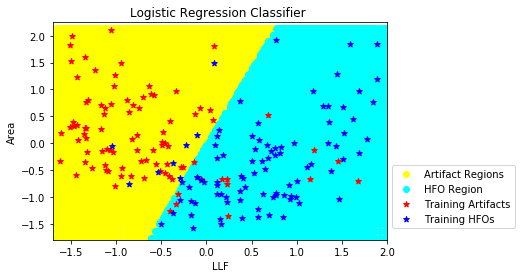

In [112]:
# implement logistical regression model
predicted_values = model.predict(input_reshape)

# reshape the predictions back into a grid
zz = predicted_values.reshape(xx.shape)

#split the points into artifacts and HFOs
artifact_mesh_bool = [zz == 0]
HFO_mesh_bool = [zz == 1]

#plot the data
plt.scatter(xx[artifact_mesh_bool], yy[artifact_mesh_bool], color = 'yellow', marker = 'o', label = "Artifact Regions")
plt.scatter(xx[HFO_mesh_bool], yy[HFO_mesh_bool], color = 'cyan', marker = 'o', label = "HFO Region")
plt.scatter(norm_LL_train[artifact_bool_index], norm_Area_train[artifact_bool_index], color = 'red', marker='*', label = "Training Artifacts")
plt.scatter(norm_LL_train[HFO_bool_index], norm_Area_train[HFO_bool_index],  color ='blue', marker='*', label = "Training HFOs")

plt.xlim([-1.7, 2])
plt.ylim([-1.8, 2.25])
plt.xlabel("LLF")
plt.ylabel("Area")
plt.title("Logistic Regression Classifier ")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.2))

/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


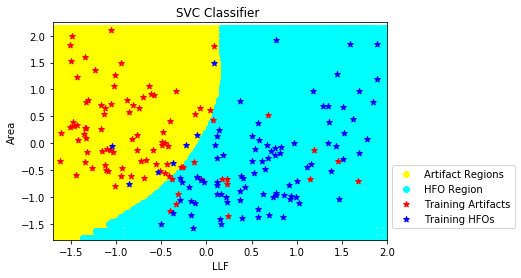

In [113]:
#support vector machine (SVM) 
predicted_values = svc.predict(input_reshape)

# # reshape the predictions back into a grid
zz = predicted_values.reshape(xx.shape)

#split the points into artifacts and HFOs
artifact_mesh_bool = [zz == 0]
HFO_mesh_bool = [zz == 1]

#plot the data
plt.scatter(xx[artifact_mesh_bool], yy[artifact_mesh_bool], color = 'yellow', marker = 'o', label = "Artifact Regions")
plt.scatter(xx[HFO_mesh_bool], yy[HFO_mesh_bool], color = 'cyan', marker = 'o', label = "HFO Region")
plt.scatter(norm_LL_train[artifact_bool_index], norm_Area_train[artifact_bool_index], color = 'red', marker='*', label = "Training Artifacts")
plt.scatter(norm_LL_train[HFO_bool_index], norm_Area_train[HFO_bool_index],  color ='blue', marker='*', label = "Training HFOs")

plt.xlim([-1.7, 2])
plt.ylim([-1.8, 2.25])
plt.xlabel("LLF")
plt.ylabel("Area")
plt.title("SVC Classifier ")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.2))

/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/Users/tshepoyane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


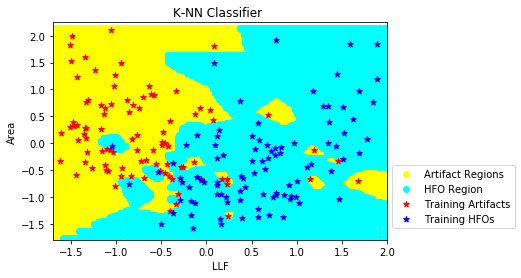

In [114]:
#support vector machine (SVM) 
predicted_values = neigh.predict(input_reshape)

# # reshape the predictions back into a grid
zz = predicted_values.reshape(xx.shape)

#split the points into artifacts and HFOs
artifact_mesh_bool = [zz == 0]
HFO_mesh_bool = [zz == 1]

#plot the data
plt.scatter(xx[artifact_mesh_bool], yy[artifact_mesh_bool], color = 'yellow', marker = 'o', label = "Artifact Regions")
plt.scatter(xx[HFO_mesh_bool], yy[HFO_mesh_bool], color = 'cyan', marker = 'o', label = "HFO Region")
plt.scatter(norm_LL_train[artifact_bool_index], norm_Area_train[artifact_bool_index], color = 'red', marker='*', label = "Training Artifacts")
plt.scatter(norm_LL_train[HFO_bool_index], norm_Area_train[HFO_bool_index],  color ='blue', marker='*', label = "Training HFOs")

plt.xlim([-1.7, 2])
plt.ylim([-1.8, 2.25])
plt.xlabel("LLF")
plt.ylabel("Area")
plt.title("K-NN Classifier ")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.2))


In a few sentences, lets report some observations about the three plots, especially similarities and differences between them. Which of these has overfit the data the most? Which has underfit the data the most? 

The boudaries of the  different models vary in shape but they all have a good number of data points that have been claissfied by the models.

The K-nn model seems to overfit the data because it has doesn't have a clear bondary layer in compared to the ottehr models used. The logistic regresion seems to underfit the data the most beacuse the boundary does not still has a lot of overlap between the true value obtained. The SVC has the best classification boundary as it maximises the number of true HFO and artifacts. 

## 4. Cross-Validation
In this section, we will investigate the importance of cross-validation, which is essential for choosing the tunable parameters of a model (as opposed to the internal parameters the  classifier "learns" by itself on the training data).


Since you cannot do any validation on the testing set, you'll have to split up the training set. 
One way of doing this is to randomly split it into k unique "folds," with roughly the same number of samples (n/k for n total training samples). Then you can create different training and validation splits, using k-1 of the folds as training data and the remaining fold as validation data. In this question, you will perform 10-fold cross-validation. 

Letsuse [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and [`.split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split) to create 10 random train/validation splits using the training data only.


How are these splits represented using `KFold`? How are they related to the folds?

The splits are represented by a k by 2 array where k is the number of splits and the 2 columns are contain the indicies of the training and testing data to be used for validation which is 10. You get k-1 training windows and 1 testing window


Create a list to hold the indices of each of these splits, something of the form `[(training_indices, testing_indices), (training_indices, testing_indices), ...]`. How many training and testing examples are in each split? Is that expected? (1 pt)

In [115]:
k=10
kf=KFold(n_splits=k)
split=kf.split(x_training_data)

split_ind=[]
for train_index, test_index in split:
    split_ind.append([train_index,test_index])

In [116]:
x=split_ind[0]
len(x) # length of testing samples
print(x[1])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [117]:
x_training_data[2,:]

array([-1.16548158,  0.7135882 ])

There are 180 trainning samples and 20 test samples in each of the 10 splits.  


Train new *k*-NN models (with the same parameters as before) on each of the 10 folds.



Report the validation score for each model on their respective splits. 


In [118]:
neigh = KNeighborsClassifier(n_neighbors=1)
score_store=[]

for i in range(len(split_ind)):

    data_slice=split_ind[i]

    train_ind=data_slice[0]
    test_ind=data_slice[1]

    X_train=x_training_data[train_ind]
    Y_train=y_training_data[train_ind]

    X_test=x_training_data[test_ind]
    Y_test=y_training_data[test_ind]
    
    neigh.fit(X_train,Y_train)
    niegh_score=neigh.score(X_test,Y_test)
    score_store.append(niegh_score)

print(score_store)

[0.9, 0.9, 0.85, 0.85, 0.8, 0.85, 0.75, 0.75, 0.7, 0.8421052631578947]


Each split  yeilded a score of 0.9,  0.9,  0.85,  0.85,  0.8,  0.85,   0.75,   0.75,  0.7,   0.842105263157894


Calculate the average validation score. How does this validation score compare to the testing score from last one? Does this make sense? Why is it called validation score and not a testing score?

In [119]:
K_NN_mean_val=np.mean(score_store)
K_NN_mean_val

0.8192105263157895

In [120]:
# accuiracy double check

from sklearn.model_selection import cross_val_score

kf=KFold(n_splits=10)
split=kf.split(x_training_data)

result = cross_val_score(neigh, x_training_data, y_training_data, cv = kf)
 
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.8192105263157895


The average score is still 0.82 which is still similar to the testing score from the last question. It is called the validation score because of the combinations of data you  look at can get random pairings with very low scores which  can bring the validation score down below the testing score.


Now, let's optimize our *k*-NN model by creating a parameter space for the *k*-NN model and testing possible *k* values from 1 - 30. 


One way we can do this is by creating 30 folds. For each fold, we train a different *k*-NN model with a different *k*, and evaluate each on its respective validation set. We then pick the *k* with the best validation score. 


[1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 1.0, 1.0, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0, 0.6666666666666666]
[1.0, 0.921875, 0.90625, 0.890625, 0.890625, 0.8854166666666666, 0.8697916666666666, 0.8958333333333334, 0.8802083333333334, 0.875, 0.8645833333333334, 0.875, 0.875, 0.875, 0.8802083333333334, 0.8697916666666666, 0.875, 0.8645833333333334, 0.8541666666666666, 0.8652849740932642, 0.8808290155440415, 0.8756476683937824, 0.8704663212435233, 0.8652849740932642, 0.8704663212435233, 0.8911917098445595, 0.8808290155440415, 0.8704663212435233, 0.8808290155440415, 0.8808290155440415]


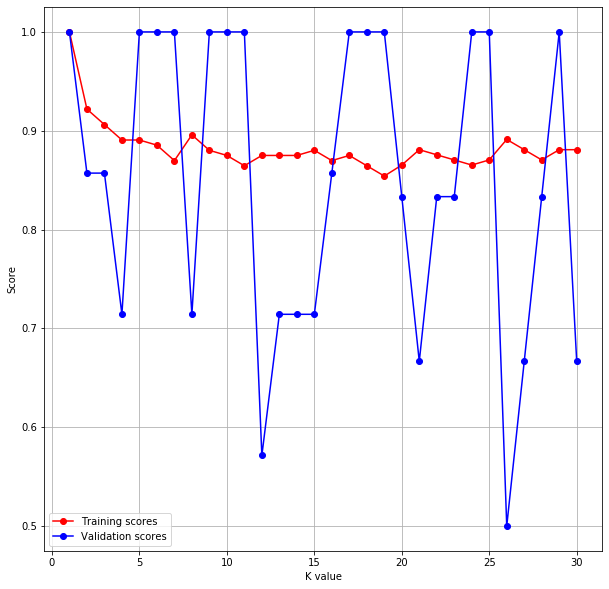

In [121]:
#Split the data into 30 folds

n_folds=30
kf=KFold(n_splits=n_folds)
split=kf.split(x_training_data)

split_ind=[]
for train_index, test_index in split:
    split_ind.append([train_index,test_index])
K=np.arange(1,n_folds+1)

score_store_train=[]
score_store_test=[]

for j in range(len(split_ind)):

    neigh = KNeighborsClassifier(n_neighbors=(j+1))

    data_slice=split_ind[j]

    train_ind=data_slice[0]
    test_ind=data_slice[1]

    X_train=x_training_data[train_ind]
    Y_train=y_training_data[train_ind]

    X_test=x_training_data[test_ind]
    Y_test=y_training_data[test_ind]
    


    neigh.fit(X_train,Y_train)
    niegh_score=neigh.score(X_test,Y_test)
    score_store_test.append(niegh_score)


    niegh_score=neigh.score(X_train,Y_train)
    score_store_train.append(niegh_score)
   
print(score_store_test)
print(score_store_train)
# plotting data

plt.figure(figsize=(10,10))
plt.plot(K,score_store_train,"-o", color="red",label="Training scores")
plt.plot(K,score_store_test,"-o", color="blue", label="Validation scores")
plt.xlabel("K value")
plt.ylabel("Score")
plt.legend()
plt.grid()


A better way we can perform this Model Selection is by creating 10 folds. Then, for each `k`, we perform 10-fold cross-validation (each *k* will have the same folds) as we did before. Lets plot the mean training and validation scores for each *k* using this method of model selection. 

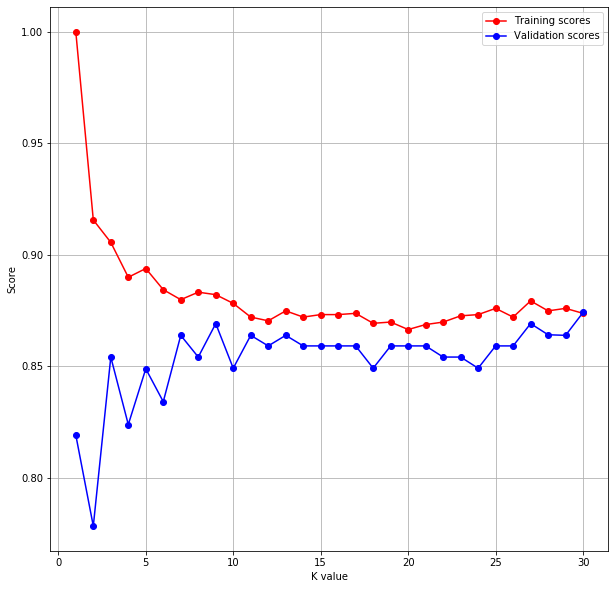

In [122]:
#Split the data into 30 folds

n_folds=10 # number of splits
max_K=30 # max K value 
K_array=np.arange(1,max_K+1,1)  # array of value K from 1 to 30



validation_score_store=np.zeros((max_K,n_folds))
training_score_store=np.zeros((max_K,n_folds))

k_split_ind=[]
#split the data in 10 chucks
kf=KFold(n_splits=n_folds)
split=kf.split(x_training_data)

for train_index, test_index in split:
    k_split_ind.append([train_index,test_index])


# go through each K value  and make  10 folds
for i in range(max_K):
    for j in range(len(k_split_ind)):

        


        neigh = KNeighborsClassifier(n_neighbors=(i+1))

        data_slice=k_split_ind[j]

        train_ind=data_slice[0]
        test_ind=data_slice[1]

        X_train=x_training_data[train_ind]
        Y_train=y_training_data[train_ind]

        X_test=x_training_data[test_ind]
        Y_test=y_training_data[test_ind]

        neigh.fit(X_train,Y_train)

        niegh_score_train=neigh.score(X_train,Y_train)
        training_score_store[i,j]=niegh_score_train

        niegh_score_test=neigh.score(X_test,Y_test)
        validation_score_store[i,j]=niegh_score_test

training_score_mean_array=np.mean(training_score_store,axis=1)
validation_score_mean_array=np.mean(validation_score_store,axis=1)

# plot the data

plt.figure(figsize=(10,10))
plt.plot(K_array,training_score_mean_array,"-o", color="red",label="Training scores")
plt.plot(K_array,validation_score_mean_array,"-o", color="blue", label="Validation scores")
plt.xlabel("K value")
plt.ylabel("Score")
plt.legend()
plt.grid()

The optimal value of K is 30 neighbours

In [123]:

best_k=30

#### 
Explain why *k*-NN generally overfits less with higher values of *k*.


When you fit the k-NN model, you use a dataset that you assume is a sample of the real statistical distribution you want to model. This means that the dataset does not fully reflect the real distribution and will contain anomalies, exceptions or some randomness. An overfitted model would stick too much to the particularities of this dataset and be too variant, instead of learning statistical patterns that would smooth these particularities and bring the model closer to the real statistical distribution.

In the case of KNN, K controls the size of the neighborhood used to model the local statistical properties. A very small value for K makes the model more sensitive to local anomalies and exceptions, giving too many weight to these particular points. On the contrary, a too large value of K would make the model ignore the local structure of the distribution you try to learn, and produce an underfitted model

 
Now that we know the "best" *k*, train a new *k*-NN model with it using the entirety of the training data and evaluate it on the testing data. 

In [124]:
#your code here
#training data
best_k=30

neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_training_data,y_training_data)
niegh_score=neigh.score(x_training_data,y_training_data)
print(f'The the K-NN score is {niegh_score}')

#testing data

niegh_score_test=neigh.score(x_test_data,y_test_data)
print(f'The the K-NN score is {niegh_score_test}')

The the K-NN score is 0.8793969849246231
The the K-NN score is 0.8833333333333333



 What is the testing score?

The testing score is 0.88 from the SVC model